In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)

dc_listings = pd.read_csv("dc_airbnb.csv")
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 574 to 1061
Data columns (total 19 columns):
host_response_rate      3289 non-null object
host_acceptance_rate    3109 non-null object
host_listings_count     3723 non-null int64
accommodates            3723 non-null int64
room_type               3723 non-null object
bedrooms                3702 non-null float64
bathrooms               3696 non-null float64
beds                    3712 non-null float64
price                   3723 non-null float64
cleaning_fee            2335 non-null object
security_deposit        1426 non-null object
minimum_nights          3723 non-null int64
maximum_nights          3723 non-null int64
number_of_reviews       3723 non-null int64
latitude                3723 non-null float64
longitude               3723 non-null float64
city                    3723 non-null object
zipcode                 3714 non-null object
state                   3723 non-null object
dtypes: float64(6), int64(5), objec

Using Multivariate K-Nearest Neighbors machine learning model going to predict the rent price.There are 2 ways we can tweak the model to try to improve the accuracy
- select the relevant attributes the model uses to calculate similarity when ranking the closest neighbors
- increase k, the number of nearby neighbors the model uses when computing the prediction

####  Removing Features
When selecting more attributes to use in the model, we need to watch out for columns that don't work well with the distance equation. This includes columns containing:

-  non-numerical columns
- non-ordinal columns
- missing values



In [2]:
drop_columns =['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings = dc_listings.drop(drop_columns, axis=1)
dc_listings.isnull().sum()

accommodates            0
bedrooms               21
bathrooms              27
beds                   11
price                   0
cleaning_fee         1388
security_deposit     2297
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64

Since 3 columns have 1% of missing values 
- bedrooms
- bathrooms
- beds

There are also 2 columns that have a large number of missing values:
- cleaning_fee - 37.3% of the rows
- ecurity_deposit - 61.7% of the rows

In [3]:
dc_listings = dc_listings.drop(['cleaning_fee', 'security_deposit'], axis=1)
dc_listings = dc_listings.dropna(axis=0)
print(dc_listings.isnull().sum())

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


#### Normalize columns
while the accommodates, bedrooms, bathrooms, beds, and minimum_nights columns hover between 0 and 12,the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 4 and as high as 1825, in the first few rows itself.

if we use these 2 columns(maximum_nights and number_of_reviews) the as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations, because of the largeness of the values.

To prevent any single column from having the impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.Normalizing the values in each column to the standard normal distribution



In [4]:
dc_listings.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
574,2,1.0,1.0,1.0,125.0,1,4,149
1593,2,1.0,1.5,1.0,85.0,1,30,49
3091,1,1.0,0.5,1.0,50.0,1,1125,1
420,2,1.0,1.0,1.0,209.0,4,730,2
808,12,5.0,2.0,5.0,215.0,2,1825,34


In [5]:
normalized_listings = (dc_listings - dc_listings.mean())/ (dc_listings.std())
normalized_listings ['price']= dc_listings['price']
print(normalized_listings.head(3))

      accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
574      -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1593     -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
3091     -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   

      maximum_nights  number_of_reviews  
574        -0.016604           4.579650  
1593       -0.016603           1.159275  
3091       -0.016573          -0.482505  


#### Euclidean distance for multivariate case
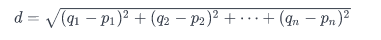

In [6]:
from scipy.spatial import distance
first_listing= normalized_listings.iloc[0][['accommodates','bathrooms']]
fifth_listing = normalized_listings.iloc[4][['accommodates','bathrooms']]
first_fifth_distance = distance.euclidean(first_listing, fifth_listing)
print(first_fifth_distance)

5.272543124668403


#### scikit-learn

The scikit-learn workflow consists of 4 main steps:

- instantiate the specific machine learning model you want to use
- fit the model to the training data
- use the model to make predictions
- evaluate the accuracy of the predictions

In [7]:
from sklearn.neighbors import KNeighborsRegressor

train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]
train_columns = train_df[['accommodates','bathrooms']]
target_data = train_df['price']
test_column = test_df[['accommodates','bathrooms']]

# Instantiate ML model.
knn = KNeighborsRegressor(n_neighbors = 5, algorithm= 'brute')

#fit the model to data
knn.fit(train_columns, target_data)

# use the model to predict
predictions = knn.predict(test_column)

#### Calculating MSE using Scikit-Learn

In [8]:
from sklearn.metrics import mean_squared_error

train_columns = ['accommodates', 'bathrooms']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
predictions = knn.predict(test_df[train_columns])
two_features_mse =mean_squared_error(test_df['price'], predictions)
two_features_rmse = two_features_mse**(1/2)
print(two_features_mse)
print(two_features_rmse)

15732.094061433445
125.42764472568814


train a model using the following 4 features:

In [9]:
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')
knn.fit(train_df[features], train_df['price'])
four_predictions = knn.predict( test_df[features])
four_mse = mean_squared_error(test_df['price'], four_predictions)
four_rmse = four_mse ** (1/2)
print(four_mse)
print(four_rmse)

13295.509533560866
115.30615566204983


As we increased the features the model used, we observed lower MSE and RMSE values:

In [10]:
features =train_df.columns.tolist()
features.remove('price')

knn.fit(train_df[features], train_df['price'])
all_features_predictions = knn.predict(test_df[features])
all_features_mse = mean_squared_error(test_df['price'],all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)
print(all_features_mse)
print(all_features_rmse)

15362.723868031851
123.94645564933211


RMSE value actually increased to 125.1 when we used all of the features available to us. This means that selecting the right features is important and that using more features doesn't automatically improve prediction accuracy